# Testing Attention Mechanisms

This notebook demonstrates and visualizes the implementation of:
1. DilatedAttention
2. MultiheadDilatedAttention

We'll create some sample inputs and visualize how the attention patterns work.

In [1]:
import os
os.chdir("../")

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, einsum

from model import DilatedAttention, MultiheadDilatedAttention, GPTConfig

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
import torch.nn as nn
import torch
import xformers.ops as xops
import torch.nn.functional as F

class DilatedAttention(nn.Module):
    """
    Implement dilated, scaled dot product attention with softmax.

    Arguments:
    ---------
        softmax_scale: The temperature to use for the softmax attention.
                       (default: 1/sqrt(d_keys) where d_keys is computed at runtime)
        attention_dropout: The dropout rate to apply to the attention (default: 0.0)
    """

    def __init__(self, segment_lengths, dilation_rates, softmax_scale=None, attention_dropout=0.0, ops=False):
        super().__init__()
        if len(segment_lengths) != len(dilation_rates):
            raise ValueError(
                "segment_lengths and dilation_rates must have the same length")

        self.segment_lengths = segment_lengths
        self.dilation_rates = dilation_rates
        self.softmax_scale = softmax_scale
        self.dropout_p = attention_dropout
        self.ops = ops
        self.op = None

    def forward(self, query, key, value, is_causal=False):
        # Notation:
        #   B - batch size
        #   T - sequence length
        #   H - number of heads
        #   D - embedding dimension
        #   S - segment length
        #   R - dilation rate
        #   G - group size (i.e., number of heads per segment length)
        #
        # Input shape of query, key, value: (B, T, H, D)
        B, _, H, _ = query.shape
        out = torch.zeros_like(query)

        # Divide into groups for each dilation rate and segment length (the two lists have the same size)
        num_groups = len(self.dilation_rates)
        group_sizes = [H // num_groups] * num_groups

        attn_weights_agg = []

        # Groups are not necessarily equal
        for i in range(H % num_groups):
            group_sizes[i] += 1

        for i, (G, R, S) in enumerate(zip(group_sizes, self.dilation_rates, self.segment_lengths)):
            # Split the input sequences into segments of length 'S'
            q = rearrange(query, "B (T S) H D -> B T S H D", S=S)
            k = rearrange(key, "B (T S) H D -> B T S H D", S=S)
            v = rearrange(value, "B (T S) H D -> B T S H D", S=S)
            # Apply dilation and segment offset
            offset = i % R
            hmin = i * G
            hmax = (i + 1) * G
            q = q[:, :, offset::R, hmin:hmax, :]
            k = k[:, :, offset::R, hmin:hmax, :]
            v = v[:, :, offset::R, hmin:hmax, :]
            # Fold all 'T' segments into the batch dimension
            q = rearrange(q, "B T S H D -> (B T) S H D")
            k = rearrange(k, "B T S H D -> (B T) S H D")
            v = rearrange(v, "B T S H D -> (B T) S H D")

            if self.ops:
                # Apply memory-efficient attention
                attn_bias = xops.LowerTriangularMask() if is_causal else None
                x = xops.memory_efficient_attention(
                    query=q, key=k, value=v, op=self.op, attn_bias=attn_bias)
                

            else:
                # Compute attention scores
                attn_logits = einsum(q, k, 'B S1 H D, B S2 H D -> B S1 S2 H')
                if self.softmax_scale is None:
                    softmax_scale = 1.0 / torch.sqrt(torch.tensor(D, dtype=torch.float32))
                else:
                    softmax_scale = self.softmax_scale
                attn_logits = attn_logits * softmax_scale

                if is_causal:
                    mask = torch.tril(torch.ones(S, S)).to(attn_logits.device)
                    attn_logits = attn_logits.masked_fill(mask == 0, float('-inf'))

                attn_weights = F.softmax(attn_logits, dim=-1)
                attn_weights_agg.append(rearrange(attn_weights, "(B T) S1 S2 H-> B T S1 S2 H", B=B))
                attn_weights = F.dropout(attn_weights, p=self.dropout_p, training=self.training)
                # Compute attention output
                x = einsum(attn_weights, v, 'B S S2 H, B S H D -> B S H D')

            # Unfold 'T' segments back out of the batch dimension
            x = rearrange(x, "(B T) S H D -> B T S H D", B=B)

             # Normalize attention outputs across the sequence length dimension
            x = x / x.sum(dim=(1, 2), keepdim=True)

            # Gather the attention outputs from each dilation rate / segment length
            out = rearrange(out, "B (T S) H D -> B T S H D", S=S)
            out[:, :, offset::R, hmin:hmax, :] += x
            out = rearrange(out, "B T S H D -> B (T S) H D", S=S)

        # Normalize across all attention outputs by dividing by the number of attention groups
        return out / num_groups, attn_weights_agg


class MultiheadDilatedAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # Key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(
            config.n_embd, 3 * config.n_embd, bias=config.bias)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # Regularization
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.attention = DilatedAttention(
            segment_lengths=[2048, 2048, 2048, 2048],
            dilation_rates=[1, 2, 4, 8],
            attention_dropout=config.dropout
        )

    def forward(self, x):
        B, T, D = x.size()  # Batch size, sequence length, embedding dimensionality (n_embd)

        # Calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, D // self.n_head)  # (B, T, H, D)
        q = q.view(B, T, self.n_head, D // self.n_head)  # (B, T, H, D)
        v = v.view(B, T, self.n_head, D // self.n_head)  # (B, T, H, D)
        y = self.attention(q, k, v, is_causal=True)
        y = rearrange(y, 'B T H D -> B T (H D)')
        y = self.resid_dropout(self.c_proj(y))
        return y

## 1. Testing DilatedAttention

Let's create a small example to visualize how the dilated attention works with different segment lengths and dilation rates.

In [6]:
# Create sample inputs
B, T, H, D = 1, 16, 4, 8  # batch, seq_len, heads, dim
query = torch.randn(B, T, H, D).to(device)
key = torch.randn(B, T, H, D).to(device)
value = torch.randn(B, T, H, D).to(device)

# Initialize attention with different segment lengths and dilation rates
segment_lengths = [16, 16, 16, 16]  # 4 segments of length 4
dilation_rates = [1, 2, 4, 8]   # different dilation rates
attention = DilatedAttention(segment_lengths, dilation_rates).to(device)

# Forward pass
output, att_agg = attention(query, key, value)

print(f"Input shape: {query.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 16, 4, 8])
Output shape: torch.Size([1, 16, 4, 8])


In [8]:
for i in range(len(att_agg)):
    print(att_agg[i].shape)

torch.Size([1, 1, 16, 16, 1])
torch.Size([1, 1, 8, 8, 1])
torch.Size([1, 1, 4, 4, 1])
torch.Size([1, 1, 2, 2, 1])


### Visualizing Attention Patterns

Let's create a function to visualize the attention patterns for each head and dilation rate.

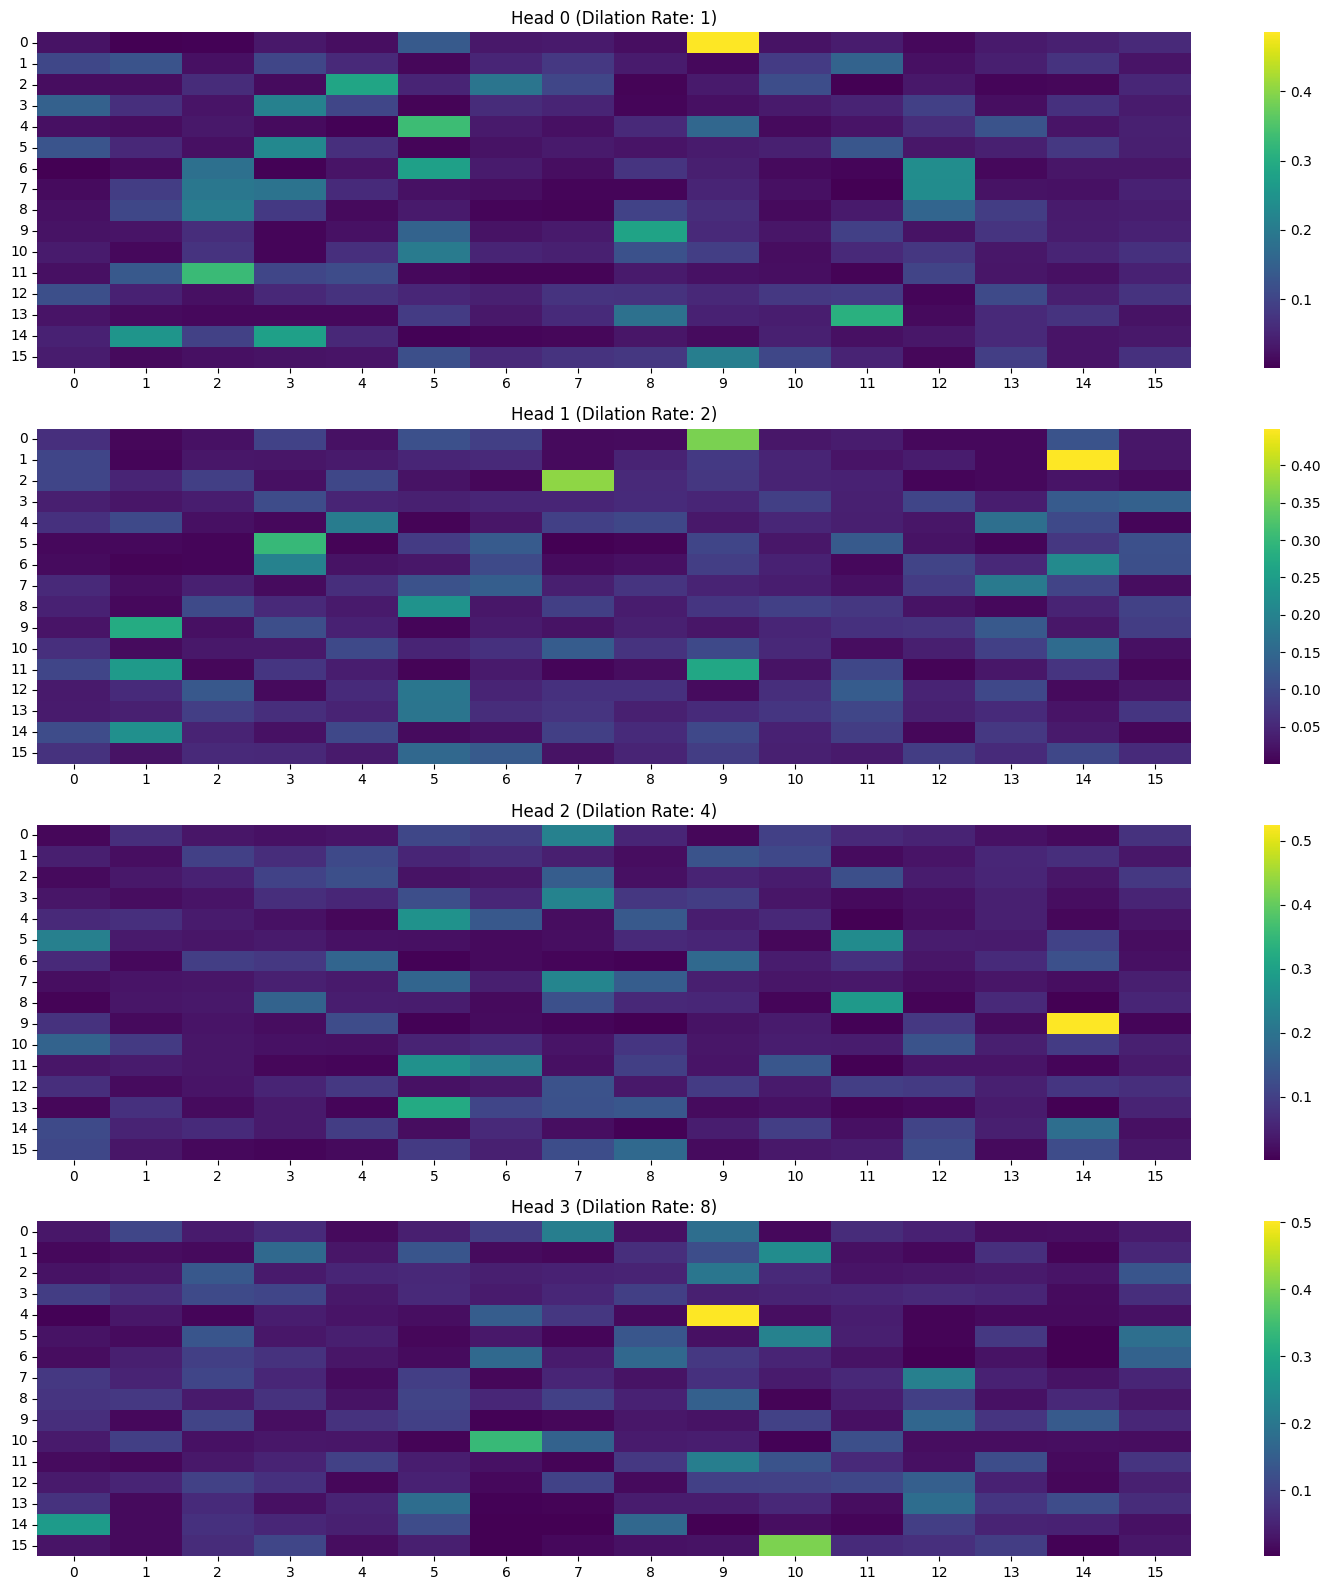

In [ ]:
def visualize_attention_patterns(query, key, value, attention, title="Attention Patterns"):
    # Get attention scores
    B, T, H, D = query.shape
    num_groups = len(attention.dilation_rates)
    
    # Create a figure with subplots for each head
    fig, axes = plt.subplots(H, 1, figsize=(15, 4*H))
    if H == 1:
        axes = [axes]
    
    for h in range(H):
        # Calculate attention scores for this head
        q = query[0, :, h, :]  # (T, D)
        k = key[0, :, h, :]    # (T, D)
        
        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(D)
        
        # Apply softmax
        attn = torch.softmax(scores, dim=-1)
        
        # Plot attention pattern
        sns.heatmap(attn.detach().cpu().numpy(), 
                   ax=axes[h],
                   cmap='viridis',
                   xticklabels=True,
                   yticklabels=True)
        axes[h].set_title(f"Head {h} (Dilation Rate: {attention.dilation_rates[h % num_groups]})")
    
    plt.tight_layout()
    plt.show()

# Visualize attention patterns
visualize_attention_patterns(query, key, value, attention)

## 2. Testing MultiheadDilatedAttention

Now let's test the MultiheadDilatedAttention which combines the dilated attention with multi-head attention.

In [ ]:
# Create a config for MultiheadDilatedAttention
config = GPTConfig(
    block_size=16,
    n_head=4,
    n_embd=32,
    dropout=0.0
)

# Initialize the attention module
multihead_attention = MultiheadDilatedAttention(config).to(device)

# Create sample input
x = torch.randn(1, 2048, 32).to(device)  # (batch, seq_len, n_embd)

# Forward pass
output = multihead_attention(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 2048, 32])
Output shape: torch.Size([1, 2048, 32])


### Visualizing Multihead Attention Patterns

Let's visualize how the attention is distributed across different heads in the multihead attention.

In [ ]:
def visualize_multihead_attention(x, multihead_attention, title="Multihead Attention Patterns"):
    # Get the query, key, value projections
    B, T, D = x.shape
    q, k, v = multihead_attention.c_attn(x).split(D, dim=2)
    
    # Reshape for visualization
    k = k.view(B, T, multihead_attention.n_head, D // multihead_attention.n_head)
    q = q.view(B, T, multihead_attention.n_head, D // multihead_attention.n_head)
    
    # Create a figure with subplots for each head
    fig, axes = plt.subplots(multihead_attention.n_head, 1, figsize=(15, 4*multihead_attention.n_head))
    if multihead_attention.n_head == 1:
        axes = [axes]
    
    for h in range(multihead_attention.n_head):
        # Calculate attention scores for this head
        q_h = q[0, :, h, :]  # (T, D)
        k_h = k[0, :, h, :]  # (T, D)
        
        # Compute attention scores
        scores = torch.matmul(q_h, k_h.transpose(-2, -1)) / np.sqrt(D // multihead_attention.n_head)
        
        # Apply softmax
        attn = torch.softmax(scores, dim=-1)
        
        # Plot attention pattern
        sns.heatmap(attn.detach().cpu().numpy(), 
                   ax=axes[h],
                   cmap='viridis',
                   xticklabels=True,
                   yticklabels=True)
        axes[h].set_title(f"Head {h}")
    
    plt.tight_layout()
    plt.show()

# Visualize multihead attention patterns
visualize_multihead_attention(x, multihead_attention)

KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


## 3. Comparison with Standard Attention

Let's compare the attention patterns between standard attention and our dilated attention implementation.

In [ ]:
def standard_attention(query, key, value, scale=None):
    """Standard scaled dot-product attention"""
    d_k = query.size(-1)
    if scale is None:
        scale = 1.0 / math.sqrt(d_k)
    
    scores = torch.matmul(query, key.transpose(-2, -1)) * scale
    attn = torch.softmax(scores, dim=-1)
    return torch.matmul(attn, value), attn

# Create sample inputs
B, T, H, D = 1, 16, 4, 8
query = torch.randn(B, T, H, D)
key = torch.randn(B, T, H, D)
value = torch.randn(B, T, H, D)

# Get attention patterns from both implementations
_, standard_attn = standard_attention(query, key, value)
dilated_output = attention(query, key, value)

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot standard attention
sns.heatmap(standard_attn[0, 0].detach().numpy(), 
           ax=ax1,
           cmap='viridis',
           xticklabels=True,
           yticklabels=True)
ax1.set_title("Standard Attention (Head 0)")

# Plot dilated attention
scores = torch.matmul(query[0, 0], key[0, 0].transpose(-2, -1)) / np.sqrt(D)
dilated_attn = torch.softmax(scores, dim=-1)
sns.heatmap(dilated_attn.detach().numpy(), 
           ax=ax2,
           cmap='viridis',
           xticklabels=True,
           yticklabels=True)
ax2.set_title("Dilated Attention (Head 0)")

plt.tight_layout()
plt.show()